In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sympy as sym

import pycollocation
import pyam

In [3]:
pyam.__version__

'0.1.2a0'

## Defining inputs

Need to define some heterogenous factors of production...

In [4]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': 1e0, 'mu1': 0.0, 'sigma1': 1.0}

# to avoid the discontinuity at the lower bound need to add eps
eps = 1e-3
skill_bounds = [skill_params['loc1'] + eps, 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 1e0, 'mu2': 0.0, 'sigma2': 1.0}

# to avoid the discontinuity at the lower bound need to add eps
productivity_bounds = [productivity_params['loc2'] + eps, 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )

Note that we are shifting the distributions of worker skill and firm productivity to the right by 1.0 in order to try and avoid issues with having workers (firms) with near zero skill (productivity).

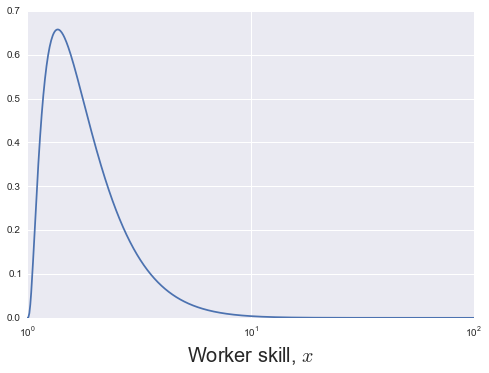

In [5]:
xs = np.linspace(workers.lower, workers.upper, 1e4)
plt.plot(xs, workers.evaluate_pdf(xs))
plt.xscale('log')
plt.xlabel('Worker skill, $x$', fontsize=20)
plt.show()

## Defining a production process

Next need to define some production process...

In [6]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [7]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.0 }

## Define a boundary value problem

In [8]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=sym.limit(F, sigma_B, 1),
                                          F_params=F_params)

## Pick some collocation solver

In [9]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [10]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 75, 'theta': 75},
                                                    exp=0.5)

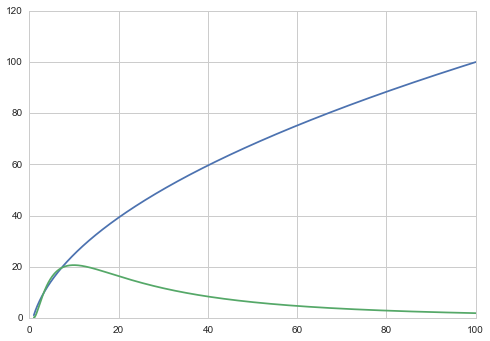

In [11]:
# quickly plot the initial conditions
sn.set_style("whitegrid")
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [12]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [13]:
solver.result.success

True

## Plot some results

In [14]:
viz = pyam.Visualizer(solver)

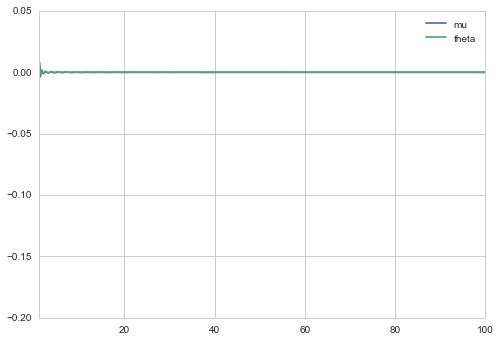

In [15]:
viz.interpolation_knots = np.logspace(1e-3, 2, 1000)
viz.residuals.plot()
plt.show()

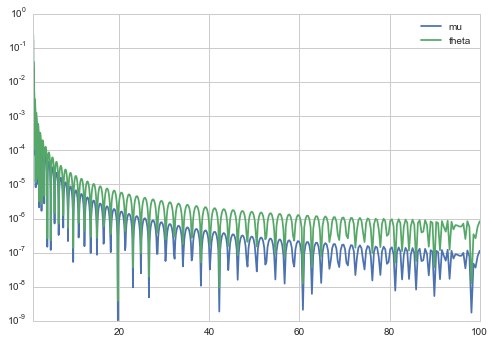

In [16]:
viz.normalized_residuals[['mu', 'theta']].plot(logy=True)
plt.show()

In [17]:
viz.solution.head()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
1.002305,0.624485,0.804715,0.402358,0.312242,0.155797,0.200761,0.077898,0.233071,0.467112,0.601924,0.233556,0.804715,0.312242,1.002604,0.388016
1.006934,0.629867,0.806573,0.403286,0.314934,0.156548,0.200467,0.078274,0.232794,0.468319,0.599703,0.234160,0.806573,0.314934,1.008358,0.390459
1.011584,0.635381,0.808436,0.404218,0.317691,0.157335,0.200187,0.078668,0.232537,0.469539,0.597424,0.234769,0.808436,0.317691,1.014238,0.392970
1.016256,0.641025,0.810305,0.405152,0.320513,0.158156,0.199921,0.079078,0.232300,0.470770,0.595089,0.235385,0.810305,0.320513,1.020240,0.395546
1.020949,0.646796,0.812180,0.406090,0.323398,0.159010,0.199668,0.079505,0.232081,0.472013,0.592705,0.236006,0.812180,0.323398,1.026361,0.398185


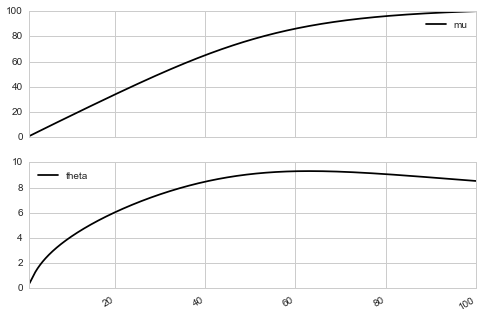

In [18]:
viz.solution[['mu', 'theta']].plot(subplots=True)
plt.show()

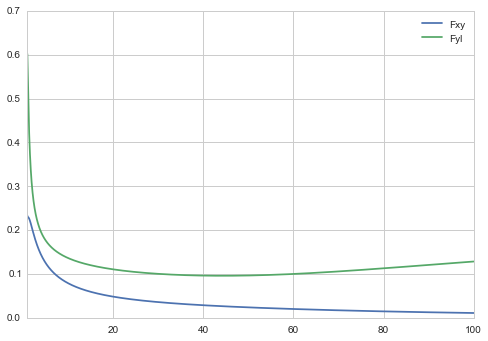

In [19]:
viz.solution[['Fxy', 'Fyl']].plot()
plt.show()

## Plot factor payments
Note the `factor_payment_1` is wages and `factor_payment_2` is profits...

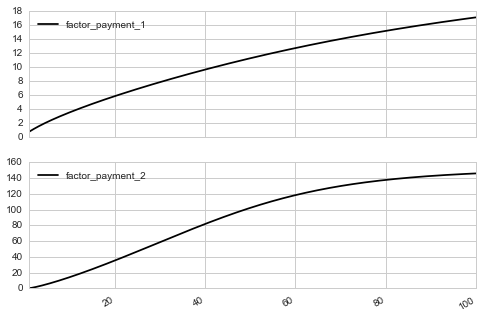

In [20]:
viz.solution[['factor_payment_1', 'factor_payment_2']].plot(subplots=True)
plt.show()

## Plot firm size against wages and profits

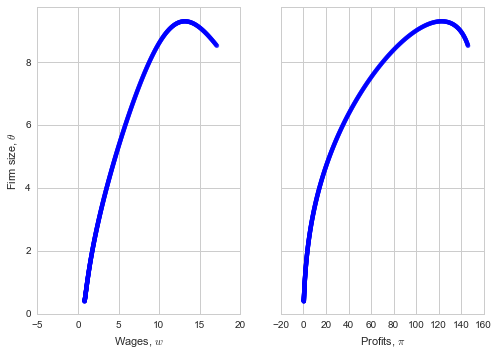

In [21]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].scatter(viz.solution.factor_payment_1, viz.solution.theta, alpha=0.5,
               edgecolor='none')
axes[0].set_ylim(0, 1.05 * viz.solution.theta.max())
axes[0].set_xlabel('Wages, $w$')
axes[0].set_ylabel(r'Firm size, $\theta$')

axes[1].scatter(viz.solution.factor_payment_2, viz.solution.theta, alpha=0.5,
               edgecolor='none')
axes[1].set_xlabel(r'Profits, $\pi$')

plt.show()

In [22]:
# to get correlation just use pandas!
viz.solution.corr()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
F,1.000000,0.993657,0.993657,1.000000,0.574843,-0.903932,0.574843,-0.774192,0.949706,-0.542494,0.949706,0.993657,1.000000,0.995088,0.915461
Fl,0.993657,1.000000,1.000000,0.993657,0.634959,-0.941929,0.634959,-0.830839,0.976000,-0.609020,0.976000,1.000000,0.993657,0.996461,0.941459
Flr,0.993657,1.000000,1.000000,0.993657,0.634959,-0.941929,0.634959,-0.830839,0.976000,-0.609020,0.976000,1.000000,0.993657,0.996461,0.941459
Fr,1.000000,0.993657,0.993657,1.000000,0.574843,-0.903932,0.574843,-0.774192,0.949706,-0.542494,0.949706,0.993657,1.000000,0.995088,0.915461
Fx,0.574843,0.634959,0.634959,0.574843,1.000000,-0.837855,1.000000,-0.929601,0.773998,-0.890980,0.773998,0.634959,0.574843,0.651167,0.854167
Fxl,-0.903932,-0.941929,-0.941929,-0.903932,-0.837855,1.000000,-0.837855,0.969077,-0.991628,0.811892,-0.991628,-0.941929,-0.903932,-0.936211,-0.982853
Fxr,0.574843,0.634959,0.634959,0.574843,1.000000,-0.837855,1.000000,-0.929601,0.773998,-0.890980,0.773998,0.634959,0.574843,0.651167,0.854167
Fxy,-0.774192,-0.830839,-0.830839,-0.774192,-0.929601,0.969077,-0.929601,1.000000,-0.930356,0.898850,-0.930356,-0.830839,-0.774192,-0.825906,-0.944406
Fy,0.949706,0.976000,0.976000,0.949706,0.773998,-0.991628,0.773998,-0.930356,1.000000,-0.758552,1.000000,0.976000,0.949706,0.971063,0.980112
Fyl,-0.542494,-0.609020,-0.609020,-0.542494,-0.890980,0.811892,-0.890980,0.898850,-0.758552,1.000000,-0.758552,-0.609020,-0.542494,-0.600973,-0.767772


In [23]:
# or a subset
viz.solution[['theta', 'factor_payment_1']].corr()

,theta,factor_payment_1
theta,1.000000,0.941459
factor_payment_1,0.941459,1.000000


In [24]:
# or actual values!
viz.solution.corr().loc['theta']['factor_payment_1']

0.94145870699713297

## Plot the density for firm size

As you can see, the theta function is hump-shaped. Nothing special, but when calculating the pdf some arrangements have to be done for this: sort the thetas preserving the order (so we can relate them to their xs) and then use carefully the right x for calculating the pdf.

The principle of Philipp's trick is:

$pdf_x(x_i)$ can be interpreted as *number of workers with ability x*. $\theta_i$ is the size of the firms that employs workers of kind $x_i$. As all firms that match with workers type $x_i$ choose the same firm size, $pdf_x(x_i)/\theta_i$ is the number of firms of size $\theta_i$.

Say there are 100 workers with ability $x_i$, and their associated firm size $\theta_i$ is 2. Then there are $100/2 = 50$ $ \theta_i$ firms

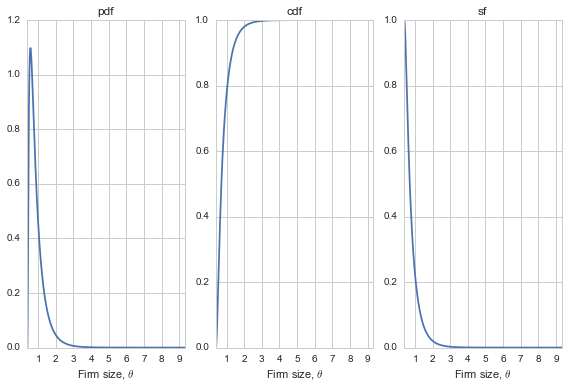

In [25]:
fig, axes = plt.subplots(1, 3)
viz.theta_pdf.plot(ax=axes[0])
axes[0].set_xlabel(r'Firm size, $\theta$')
axes[0].set_title(r'pdf')

viz.theta_cdf.plot(ax=axes[1])
axes[1].set_title(r'cdf')
axes[1].set_xlabel(r'Firm size, $\theta$')

viz.theta_sf.plot(ax=axes[2])
axes[2].set_title(r'sf')
axes[2].set_xlabel(r'Firm size, $\theta$')

plt.tight_layout()
plt.show()

## Distributions of factor payments

Is the code below correct? If so, I could add these functions as methods to the `pyam.Vizualizer` class.

In [26]:
# pdf for profits
tmp_data = sorted_data.sort('factor_payment_2', ascending=True, inplace=False)
pi_pdf = tmp_data.theta_pdf  # frequency of profits is the same as that of firms

NameError: name 'sorted_data' is not defined

In [27]:
# pdf for average wages (method A from Falter89)
tmp_data = sorted_data.sort('factor_payment_1', ascending=True, inplace=False)
w_pdf_A = tmp_data.theta_pdf

NameError: name 'sorted_data' is not defined

In [85]:
# pdf for wages (method B from Falter89)
tmp_data = sorted_data.sort('factor_payment_1', ascending=True, inplace=False)
w_pdf_B = tmp_data.theta * tmp_data.theta_pdf

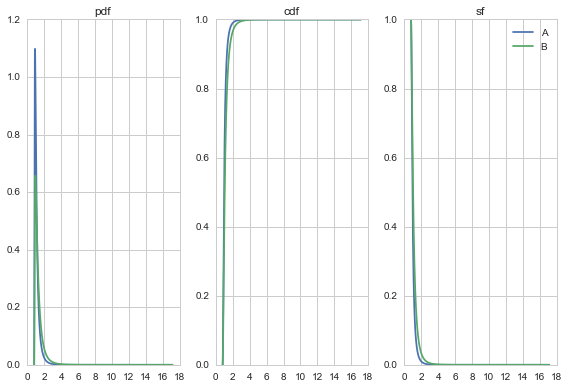

In [87]:
w_cdf_A = compute_cdf(w_pdf_A)
w_sf_A = compute_sf(w_cdf_A)

w_cdf_B = compute_cdf(w_pdf_B)
w_sf_B = compute_sf(w_cdf_B)

fig, axes = plt.subplots(1, 3)
w = viz.solution.factor_payment_1.sort(inplace=False)
axes[0].plot(w, w_pdf_A)
axes[0].plot(w, w_pdf_B)
axes[0].set_title(r'pdf')

axes[1].plot(w, w_cdf_A)
axes[1].plot(w, w_cdf_B)
axes[1].set_title(r'cdf')

axes[2].plot(w, w_sf_A, label="A")
axes[2].plot(w, w_sf_B, label="B")
axes[2].set_title(r'sf')
axes[2].legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

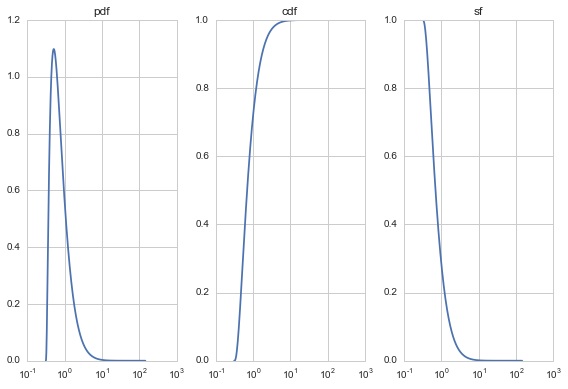

In [88]:
pi_cdf = compute_cdf(pi_pdf)
pi_sf = compute_sf(pi_cdf)

fig, axes = plt.subplots(1, 3)
pi = viz.solution.factor_payment_2.sort(inplace=False)
axes[0].plot(pi, pi_pdf)
axes[0].set_xscale('log')
axes[0].set_title(r'pdf')

axes[1].plot(pi, pi_cdf)
axes[1].set_xscale('log')
axes[1].set_title(r'cdf')

axes[2].plot(pi, pi_sf)
axes[2].set_xscale('log')
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()

## Widget

In [26]:
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [27]:
def interactive_plot(viz, omega_A=0.25, omega_B=0.5, sigma_A=0.5, sigma_B=1.0,
                     mu1=0.0, sigma1=1.0, mu2=0.0, sigma2=1.0):
    # update new parameters as needed
    new_F_params = {'omega_A': omega_A, 'omega_B': omega_B,
                    'sigma_A': sigma_A, 'sigma_B': sigma_B}
    viz.solver.problem.F_params.update(new_F_params)
    
    new_input1_params = {'mu1': mu1, 'sigma1': sigma1}
    viz.solver.problem.input1.params.update(new_input1_params)
    
    new_input2_params = {'mu2': mu2, 'sigma2': sigma2}
    viz.solver.problem.input2.params.update(new_input2_params)
    
    # solve the model using a hotstart initial guess
    domain = [viz.solver.problem.input1.lower, viz.solver.problem.input2.upper]
    initial_coefs = viz.solver._coefs_array_to_dict(viz.solver.result.x, viz.solver.degrees)
    viz.solver.solve(kind="Chebyshev",
                     coefs_dict=initial_coefs,
                     domain=domain,
                     method='hybr')
    
    if viz.solver.result.success:
        viz._Visualizer__solution = None  # should not need to access this!
        viz.solution[['mu', 'theta']].plot(subplots=True)
    else:
        print "Foobar!"

In [28]:
viz_widget = widgets.fixed(viz)

eps = 1e-2
omega_A_widget = widgets.FloatSlider(value=0.25, min=eps, max=1-eps, step=eps,
                                     description=r"$\omega_A$")
sigma_A_widget = widgets.FloatSlider(value=0.5, min=eps, max=1-eps, step=eps,
                                     description=r"$\sigma_A$")
omega_B_widget = widgets.FloatSlider(value=0.5, min=eps, max=1-eps, step=eps,
                                     description=r"$\omega_B$")
sigma_B_widget = widgets.fixed(1.0)
sigma_1_widget = widgets.FloatSlider(value=1.0, min=eps, max=2-eps, step=eps,
                                     description=r"$\sigma_1$")
sigma_2_widget = widgets.FloatSlider(value=1.0, min=eps, max=2-eps, step=eps,
                                     description=r"$\sigma_2$")
mu_1_widget = widgets.FloatSlider(value=0.0, min=0.0, max=2-eps, step=eps,
                                  description=r"$\mu_1$")
mu_2_widget = widgets.FloatSlider(value=0.0, min=0.0, max=2-eps, step=eps,
                                  description=r"$\mu_2$")


<function __main__.interactive_plot>

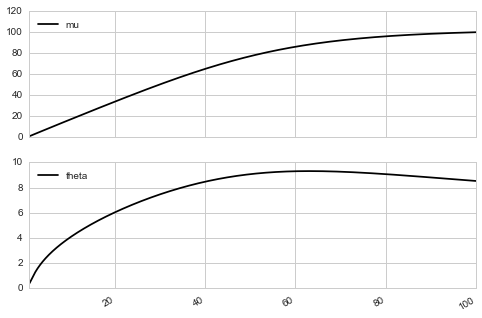

In [30]:
widgets.interact(interactive_plot, viz=viz_widget, omega_A=omega_A_widget,
                 sigma_A=sigma_A_widget, omega_B=omega_B_widget,
                 sigma_B=sigma_B_widget, sigma1=sigma_1_widget,
                 mu1 = mu_1_widget, sigma2=sigma_2_widget, mu2 = mu_2_widget)